# Import Libraries/Dataset

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras import layers
import keras

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'README', 'test']

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup',
 'urls_unsup.txt']

In [4]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [7]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Data Visualization

In [9]:
## Printing  at least two texts from each class of the dataset(pos and neg).
for text_batch, label_batch in raw_train_ds.take(1):
  pos_count = 0
  neg_count = 0
  for i in range(batch_size):
    if pos_count >= 2 and neg_count >= 2 :
      break
    if label_batch.numpy()[i] == 1 and pos_count <= 1:
      pos_count += 1
      print("Review", text_batch.numpy()[i])
      print("Label", label_batch.numpy()[i])
    if label_batch.numpy()[i] == 0 and neg_count <= 1:
      neg_count += 1
      print("Review", text_batch.numpy()[i])
      print("Label", label_batch.numpy()[i])


Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

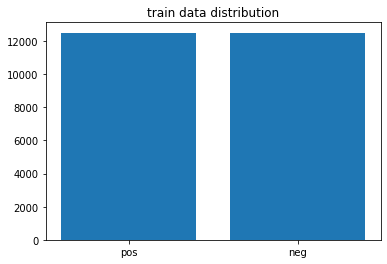

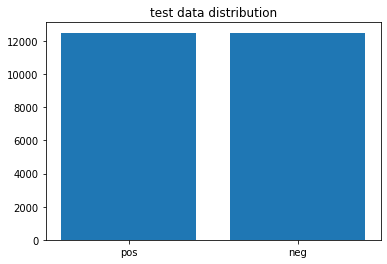

In [10]:
## Plot a bar graph of class distribution in a dataset.
train_data_dir_pos_files = len(os.listdir("aclImdb/train/pos"))
train_data_dir_neg_files = len(os.listdir("aclImdb/train/neg"))
test_data_dir_pos_files = len(os.listdir("aclImdb/test/pos"))
test_data_dir_neg_files = len(os.listdir("aclImdb/test/neg"))
cat = ['pos', 'neg']
train_counts = [train_data_dir_pos_files, train_data_dir_neg_files]
plt.bar(cat, train_counts)
plt.title("train data distribution")
plt.show()
test_counts = [test_data_dir_pos_files, test_data_dir_neg_files]
plt.bar(cat, test_counts)
plt.title("test data distribution")
plt.show()

# Data Pre-processing

Prepare the dataset for training


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [16]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configure the dataset for performance

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model-1 : Building, Compiling, Training, Evaluation

In [19]:
embedding_dim = 16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

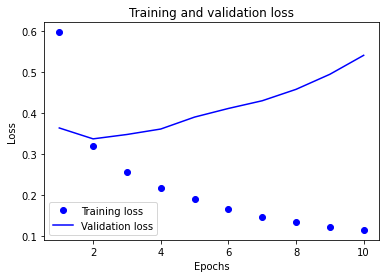

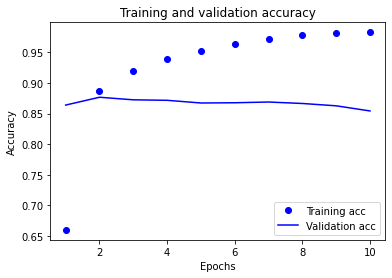

In [20]:
# Model Building
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dropout(0.2),
  layers.Dense(1)
  ])
model.summary()

# Model Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Model Training
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=400)
model_history = history


# Model Evaluation
loss, accuracy = model.evaluate(test_ds)

print("\n")
print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = model_history.history
history_dict.keys()


acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print("\n")
print("Final train and validation loss and accuracy for the Model")
print("Final Training Loss : " , loss[-1])
print("Final Training Accuracy : ", acc[-1])
print("Final Validation Loss : ", val_loss[-1])
print("Final Validation Accuracy : ", val_acc[-1])
print("\n")

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Model - 2 : Building, Compiling, Training, Evaluation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

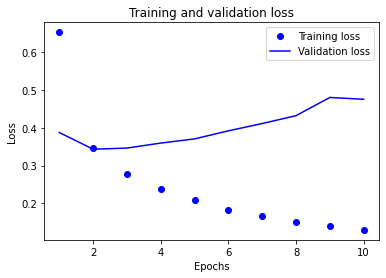

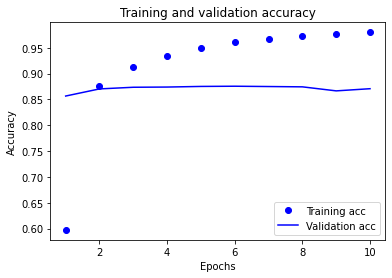

In [21]:
# Hyperparameter Tuning- 
# Dropout: Change the position and value of dropout layer

# Model Building
model_for_dropout_change = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dropout(0.4),
  layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(1)
  ])
model_for_dropout_change.summary()

# Model Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_for_dropout_change.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Model Training
epochs = 10
history = model_for_dropout_change.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=400)
# history = model_for_dropout_change.fit(train_ds, validation_data=val_ds, epochs=epochs)
model_for_dropout_change_history = history

# Model Evaluation
loss, accuracy = model_for_dropout_change.evaluate(test_ds)

print("\n")
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("\n")

history_dict = model_for_dropout_change_history.history
history_dict.keys()


acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print("\n")
print("Final train and validation loss and accuracy for the Model")
print("Final Training Loss : " , loss[-1])
print("Final Training Accuracy : ", acc[-1])
print("Final Validation Loss : ", val_loss[-1])
print("Final Validation Accuracy : ", val_acc[-1])
print("\n")

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


# Model - 3 : Building, Compiling, Training, Evaluation

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

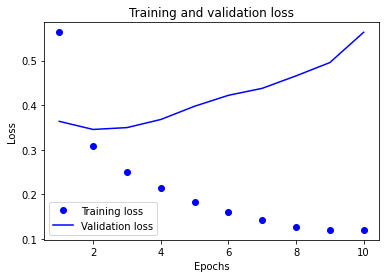

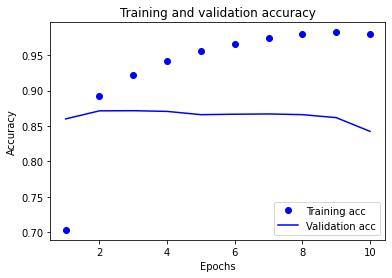

In [22]:
# Hyperparameter Tuning- 
# Batch Size: Change the value of batch size in model training


# Model Building
model_for_batch_size_change = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dropout(0.2),
  layers.Dense(1)
  ])
model_for_batch_size_change.summary()

# Model Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_for_batch_size_change.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Model Training
epochs = 10
history = model_for_batch_size_change.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=200)
model_for_batch_size_change_history = history

# Model Evaluation
loss, accuracy = model_for_batch_size_change.evaluate(test_ds)

print("\n")
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("\n")

history_dict = model_for_batch_size_change_history.history
history_dict.keys()


acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print("\n")
print("Final train and validation loss and accuracy for the Model")
print("Final Training Loss : " , loss[-1])
print("Final Training Accuracy : ", acc[-1])
print("Final Validation Loss : ", val_loss[-1])
print("Final Validation Accuracy : ", val_acc[-1])
print("\n")

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


1) DNN with 3 hidden layers
Loss:  0.635286271572113
Accuracy:  0.8299999833106995

2) Dropout: Change the position and value of dropout layer
Loss:  0.5468131899833679
Accuracy:  0.8474799990653992

3) Batch Size: Change the value of batch size in model training
Loss:  0.6669371128082275
Accuracy:  0.8165199756622314


- Based on the above model training for different hyper parameters and hidden layer configurations, the accuracy of all 3 different models, looks similar. However, the loss function is quite varying for the models. 
- For the given dataset , model with reduced batch size is having low loss function compared to the other model with standard batch size.